H vs E vs S

# Nouvelle section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.7 MB/s eta 0:00:00


Without Optimiser

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.3228 - loss: 611.4871 - val_accuracy: 0.3000 - val_loss: 91.4883
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 632ms/step - accuracy: 0.4119 - loss: 51.7944 - val_accuracy: 0.3000 - val_loss: 24.5341
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - accuracy: 0.5159 - loss: 17.3252 - val_accuracy: 0.4444 - val_loss: 38.5094
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 662ms/step - accuracy: 0.5142 - loss: 12.1062 - val_accuracy: 0.3667 - val_loss: 5.3965
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 952ms/step - accuracy: 0.7461 - loss: 1.7559 - val_accuracy: 0.5667 - val_loss: 2.0821
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 642ms/step - accuracy: 0.7285 - loss: 1.4012 - val_accuracy: 0.8778 - val_loss: 0.4029
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 947ms/step - accuracy: 0.9665 - loss: 0.0986 - val_accuracy: 0.8667 - val_loss: 1.2183
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 600ms/step - accuracy: 0.9394 - loss: 0.2247 - val_accuracy: 0.7778 - v

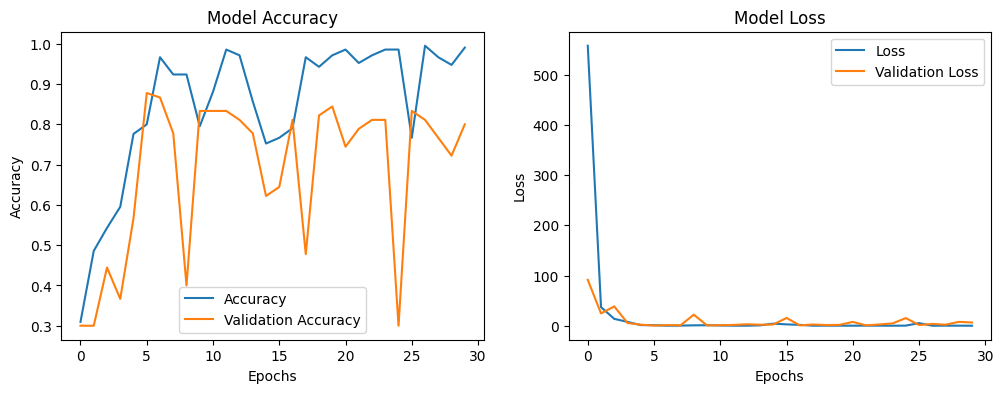

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/No_Options.keras ✅


In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time
import matplotlib.pyplot as plt
import pywt  # Importing PyWavelets for wavelet transformation

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for Wavelet Transform (db4 at level 5)
def apply_wavelet_transform(data, wavelet='db4', level=5):
    transformed_data = []
    for signal in data:
        # Apply wavelet transform (db4) at level 5
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Reconstruct the signal using the approximation and detailed coefficients
        reconstructed_signal = pywt.waverec(coeffs, wavelet)
        # Append the transformed signal (truncate to match original size)
        transformed_data.append(reconstructed_signal[:len(signal)])
    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

# Combine data and labels for Healthy + Epileptic vs Seizure
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply Wavelet Transform (db4 at level 5)
    data_all_wavelet = apply_wavelet_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes: Healthy (0), Epileptic (1), Seizure (2)
    ])

    # Compile the model
    model.compile( loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

         # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")





2 methode of decomposition

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4169 - loss: 88.8530 - val_accuracy: 0.3667 - val_loss: 45.3848
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6131 - loss: 39.4700 - val_accuracy: 0.4556 - val_loss: 39.4602
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6671 - loss: 20.1261 - val_accuracy: 0.4889 - val_loss: 37.5946
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7402 - loss: 18.8540 - val_accuracy: 0.5111 - val_loss: 44.4241
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7963 - loss: 13.3587 - val_accuracy: 0.4889 - val_loss: 43.1511
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8610 - loss: 10.3900 - val_accuracy: 0.5333 - val_loss: 42.1072
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8682 - loss: 5.8036 - val_accuracy: 0.5667 - val_loss: 37.6044
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8863 - loss: 3.7190 - val_accuracy: 0.5667 - val_

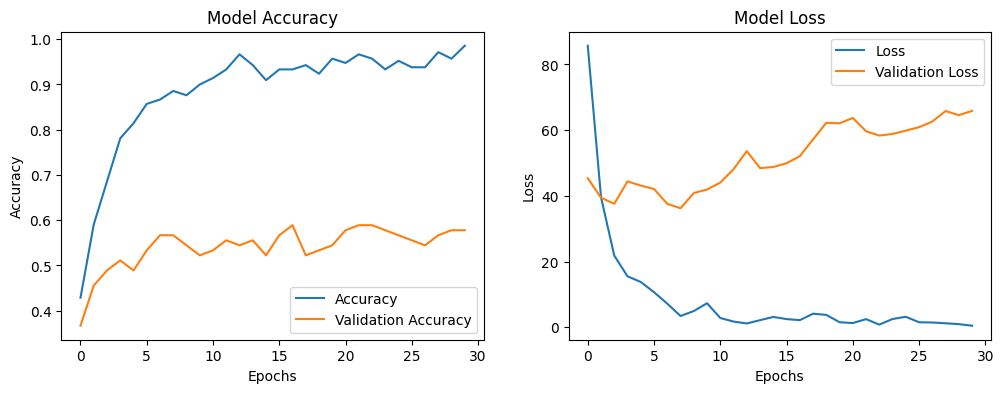

In [ ]:
import numpy as np
import pywt
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def load_data_from_directory(directory, label):
    data = []
    labels = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            signal = np.loadtxt(file_path)
            data.append(signal)
            labels.append(label)
    return np.array(data), np.array(labels)

def perform_wavelet_decomposition(data, wavelet='db4', level=5):
    decomposed_signals = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        decomposed_signals.append(coeffs)
    return decomposed_signals

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Perform wavelet decomposition
    wavelet_components = perform_wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Extract approximation and detail coefficients (A5, D5, D4, D3, D2)
    num_coeffs = 5
    padded_components = []

    for coeff in wavelet_components:
        # Ensure we only take the first 5 components (A5, D5, D4, D3, D2)
        selected_coeffs = coeff[:num_coeffs]

        # Find the maximum length of coefficients
        max_length = max([len(c) for c in selected_coeffs])

        # Pad each coefficient to the maximum length
        padded_coeffs = [np.pad(c, (0, max_length - len(c)), 'constant') for c in selected_coeffs]

        padded_components.append(np.array(padded_coeffs))

    # Combine padded components into an array
    components = np.array(padded_components)  # Shape: (num_samples, num_coeffs, max_length)

    # Reshape for training
    num_samples, num_coeffs, max_length = components.shape
    X = components.reshape(num_samples, num_coeffs * max_length)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


Code with Standardization

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 830ms/step - accuracy: 0.3714 - loss: 6.1403 - val_accuracy: 0.4000 - val_loss: 1.0411
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 939ms/step - accuracy: 0.5914 - loss: 0.8084 - val_accuracy: 0.8444 - val_loss: 0.5323
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 654ms/step - accuracy: 0.8139 - loss: 0.5179 - val_accuracy: 0.7444 - val_loss: 0.4567
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7996 - loss: 0.4528 - val_accuracy: 0.8000 - val_loss: 0.4468
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.8683 - loss: 0.4217 - val_accuracy: 0.8222 - val_loss: 0.4378
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 778ms/step - accuracy: 0.9197 - loss: 0.3140 - val_accuracy: 0.9000 - val_loss: 0.2900
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 650ms/step - accuracy: 0.9456 - loss: 0.1987 - val_accuracy: 0.8778 - val_loss: 0.2932
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 889ms/step - accuracy: 0.9213 - loss: 0.2055 - val_accuracy: 0.9222 - val_loss: 0

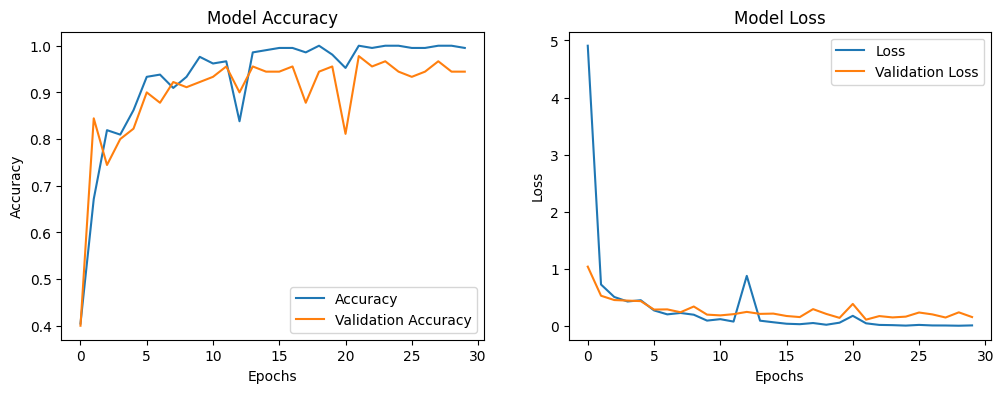

In [7]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Wavelet transform function
def apply_wavelet_transform(data, wavelet='db1', level=1):
    transformed_data = []

    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Flatten the wavelet coefficients and append to the transformed data
        transformed_data.append(np.concatenate(coeffs))

    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

# Apply wavelet transform to the data
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_Healthy = apply_wavelet_transform(data_Healthy)
    data_Epileptic = apply_wavelet_transform(data_Epileptic)
    data_Seizure = apply_wavelet_transform(data_Seizure)

    # Combine data and labels
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])

    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/With_Stander.keras"

# Save the model
model.save(model_path)



with optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.2359 - loss: 403.1328 - val_accuracy: 0.4889 - val_loss: 18.2702
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - accuracy: 0.3998 - loss: 143.1255 - val_accuracy: 0.3222 - val_loss: 24.3622
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.4786 - loss: 13.2421 - val_accuracy: 0.5667 - val_loss: 2.9682
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.6204 - loss: 3.0307 - val_accuracy: 0.6667 - val_loss: 0.7623
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.6715 - loss: 0.6576 - val_accuracy: 0.7778 - val_loss: 0.6877
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 699ms/step - accuracy: 0.8148 - loss: 0.6699 - val_accuracy: 0.4778 - val_loss: 0.7958
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 877ms/step - accuracy: 0.7392 - loss: 0.6448 - val_accuracy: 0.4667 - val_loss: 0.8014
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.7829 - loss: 0.5957 - val_accuracy: 0.7778 - val_loss: 0.8

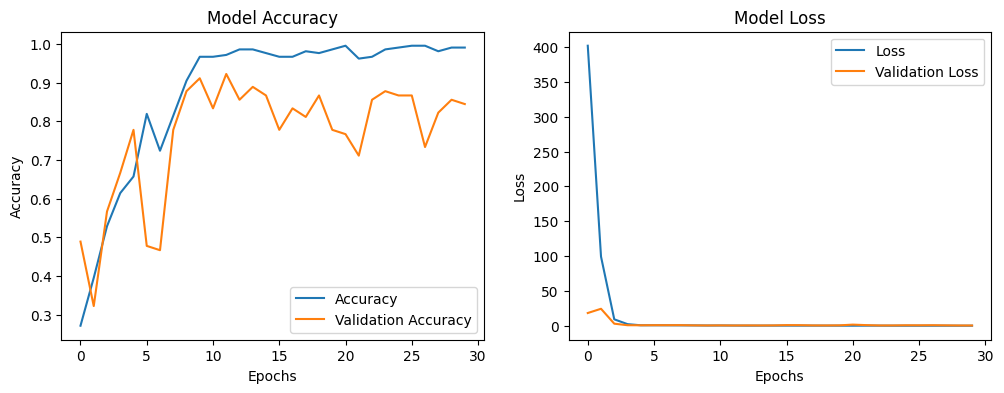

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/With_Optimiser.keras ✅


In [4]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet transform
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time
import matplotlib.pyplot as plt

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Function for Wavelet Transform (Discrete Wavelet Transform - DWT)
def wavelet_transform(data, wavelet='db4', level=1):
    transformed_data = []

    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Reconstruct the signal using approximation and details (for simplicity, using the approximation coefficients)
        # You can experiment with using different levels or parts of the coefficients
        reconstructed_signal = pywt.waverec(coeffs[:level], wavelet)  # Reconstructing with approximation
        transformed_data.append(reconstructed_signal)

    return np.array(transformed_data)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply Wavelet Transform to the data
    data_all_wavelet = wavelet_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all_wavelet, labels_all, test_size=0.3, random_state=42)

    # Define the CNN model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


     # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


Code with standarisation and Optimiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3331 - loss: 1.0662 - val_accuracy: 0.3222 - val_loss: 0.9242
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5453 - loss: 0.8323 - val_accuracy: 0.5556 - val_loss: 0.7857
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6673 - loss: 0.7676 - val_accuracy: 0.6111 - val_loss: 0.7484
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7068 - loss: 0.6657 - val_accuracy: 0.7556 - val_loss: 0.5496
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7653 - loss: 0.5879 - val_accuracy: 0.8111 - val_loss: 0.5756
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8140 - loss: 0.4887 - val_accuracy: 0.8889 - val_loss: 0.4194
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8468 - loss: 0.3766 - val_accuracy: 0.7667 - val_loss: 0.5128
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7804 - loss: 0.3888 - val_accuracy: 0.8667 - val_loss: 0.3836
Epoch 9/30

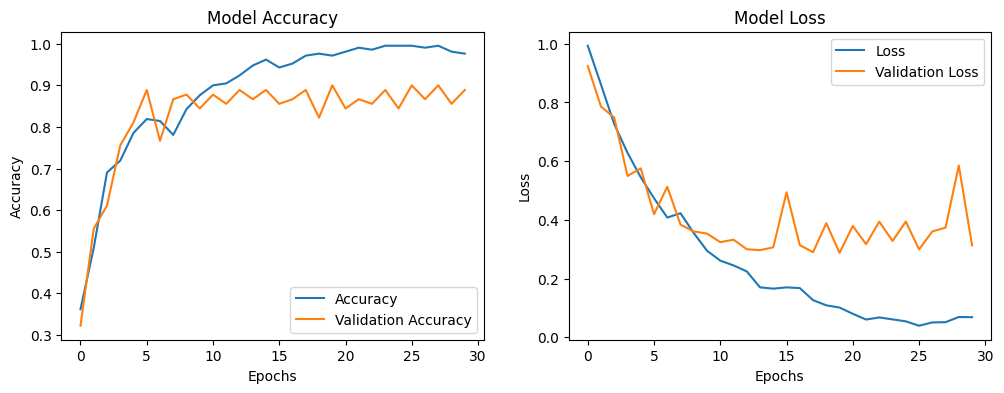

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/With_Options.keras ✅


In [3]:
import os
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
import time
import matplotlib.pyplot as plt

# Function to load data from a directory
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Wavelet Transform using Daubechies 4 wavelet and level 5 decomposition
def walvet_processing(data, wavelet='db4', level=5):
    # Perform a discrete wavelet transform (DWT) on the signal with the specified wavelet and level
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Use only the approximation coefficients from the DWT (for simplicity)
    # You could also use other coefficients depending on your needs
    return coeffs[0]

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=2)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply Wavelet Processing to the data
    data_all = np.array([walvet_processing(signal) for signal in data_all])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Apply standardization (optional, depending on your use case)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define the CNN model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes
    ])

    # Compile the model with Adam optimizer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model and track time
    start_time = time.time()
    history = model.fit(X_train[..., np.newaxis], y_train, epochs=30, batch_size=32, validation_data=(X_test[..., np.newaxis], y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test[..., np.newaxis])
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='macro')
    precision = precision_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Print metrics
    print("\nFinal Evaluation Metrics:")
    print("Test Accuracy: ", accuracy)
    print("Test Recall (Sensitivity): ", recall)
    print("Test Precision: ", precision)
    print("Test F1 Score: ", f1)
    print("Confusion Matrix: \n", conf_matrix)
    print("Training Time (seconds): ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")

      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/CNN/Exp6/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")



